# Coverage Analysis

This notebook analyzes the coverage data from CSV files in the '5xcoverage_csv_files-600-300-3' directory. We will plot coverage over time for all results, grouped by experiment number.

## Import Required Libraries

First, let's import the libraries we'll need for our analysis.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from glob import glob

# Set up the plotting style
plt.style.use('ggplot')
sns.set_theme()
plt.rcParams['figure.figsize'] = [12, 8]

## Load and Explore Data

In [2]:
# Define the base directory path
base_dir = 'data/coverup/scratch/experiment-results'

# Get all coverage CSV files from the nested directory structure
csv_files = []
file_metadata = []

# Use glob to find all coverage_*.csv files in the nested structure
pattern = os.path.join(base_dir, '*', '*', 'results-*', 'logs', 'coverage_*.csv')
found_files = glob(pattern)

def get_module_name(file_path):
    # Read the actual module name from run-info.txt
    path_parts = file_path.split(os.sep)
    base_idx = path_parts.index('experiment-results')
    
    results_dir = os.path.join(*path_parts[:base_idx + 4])  # up to results-* folder
    run_info_path = os.path.join(results_dir, 'run-info.txt')
    
    module_name = path_parts[base_idx + 1]  # fallback to directory name
    if os.path.exists(run_info_path):
        try:
            with open(run_info_path, 'r') as f:
                for line in f:
                    if line.startswith('module-name:'):
                        module_name = line.split(':', 1)[1].strip()
                        break
        except Exception as e:
            print(f"Warning: Could not read module name from {run_info_path}: {e}")
    
    return module_name

for file_path in found_files:
    # Extract metadata from the path
    path_parts = file_path.split(os.sep)
    
    # Find the indices of the relevant parts
    try:
        base_idx = path_parts.index('experiment-results')

        module_name = get_module_name(file_path)
        module_run = path_parts[base_idx + 2]
        
        # Extract TOTAL_RUN from results-{TOTAL_RUN}
        results_part = path_parts[base_idx + 3]
        total_run = results_part.replace('results-', '')
        
        csv_files.append(file_path)
        file_metadata.append({
            'file_path': file_path,
            'module_name': module_name,
            'module_run': module_run,
            'total_run': total_run,
            'filename': os.path.basename(file_path)
        })
    except (ValueError, IndexError) as e:
        print(f"Could not parse path structure for: {file_path}")

print(f"Found {len(csv_files)} CSV files in {base_dir}")
print("Example files:", csv_files[:5] if len(csv_files) >= 5 else csv_files)

# Display metadata for first few files
if file_metadata:
    print("\nFile metadata examples:")
    for i, metadata in enumerate(file_metadata[:3]):
        print(f"File {i+1}: {metadata}")

Found 150 CSV files in data/coverup/scratch/experiment-results
Example files: ['data/coverup/scratch/experiment-results/flutes/0/results-3/logs/coverage_0.csv', 'data/coverup/scratch/experiment-results/flutes/4/results-23/logs/coverage_4.csv', 'data/coverup/scratch/experiment-results/flutes/6/results-33/logs/coverage_6.csv', 'data/coverup/scratch/experiment-results/flutes/5/results-28/logs/coverage_5.csv', 'data/coverup/scratch/experiment-results/flutes/3/results-18/logs/coverage_3.csv']

File metadata examples:
File 1: {'file_path': 'data/coverup/scratch/experiment-results/flutes/0/results-3/logs/coverage_0.csv', 'module_name': 'flutes.math', 'module_run': '0', 'total_run': '3', 'filename': 'coverage_0.csv'}
File 2: {'file_path': 'data/coverup/scratch/experiment-results/flutes/4/results-23/logs/coverage_4.csv', 'module_name': 'flutes.math', 'module_run': '4', 'total_run': '23', 'filename': 'coverage_4.csv'}
File 3: {'file_path': 'data/coverup/scratch/experiment-results/flutes/6/result

In [3]:
# Let's look at the structure of the first file to understand the data
if csv_files:
    df_example = pd.read_csv(csv_files[0])
    print(f"Shape of first file: {df_example.shape}")
    print("Columns:")
    print(df_example.columns.tolist())
    print("\nFirst few rows:")
    display(df_example.head())

Shape of first file: (1, 6)
Columns:
['iteration', 'finish_timestamp', 'finish_total_time_used', 'iteration_type', 'best_coverage', 'coverage']

First few rows:


,iteration,finish_timestamp,finish_total_time_used,iteration_type,best_coverage,coverage
0,1,17,15,coverup,100,100


## Process All Data Files

Now we'll load all the CSV files and combine them into a single DataFrame, extracting the experiment number and run information from the file names.

In [4]:
def extract_info_from_file_metadata(file_path):
    """Extract experiment info from file metadata"""
    # Find the corresponding metadata for this file
    for metadata in file_metadata:
        if metadata['file_path'] == file_path:
            total_run_num = int(metadata['total_run'])
            module_run_num = int(metadata['module_run'])
            module = metadata['module_name']
            return total_run_num, module_run_num, module
    return None, None, None

# Create an empty list to store all dataframes
all_dfs = []

# Process each CSV file
for file in csv_files:
    try:
        # Extract information from filename
        total_run_num, module_run_num, module = extract_info_from_file_metadata(file)
        
        if total_run_num is not None:
            # Read the CSV file
            df = pd.read_csv(file)
            
            # Add metadata columns
            df['total_run_num'] = total_run_num
            df['module_run_num'] = module_run_num
            df['module'] = module
            
            # Append to the list of dataframes
            all_dfs.append(df)
    except Exception as e:
        print(f"Error processing {file}: {e}")

# Combine all dataframes
if all_dfs:
    combined_df = pd.concat(all_dfs, ignore_index=True)
    print(f"Combined data shape: {combined_df.shape}")
    display(combined_df.head())
else:
    print("No data files were successfully processed")

Combined data shape: (1411, 9)


,iteration,finish_timestamp,finish_total_time_used,iteration_type,best_coverage,coverage,total_run_num,module_run_num,module
0,1,17,15,coverup,100,100,3,0,flutes.math
1,1,25,24,coverup,100,100,23,4,flutes.math
2,1,16,14,coverup,100,100,33,6,flutes.math
3,1,16,14,coverup,100,100,28,5,flutes.math
4,1,25,24,coverup,100,100,18,3,flutes.math


In [5]:
# For each module, extend runs that ended early with a flat line to the module's max iteration

# 1. Find the highest iteration number for each module
module_max_iter = combined_df.groupby('module')['iteration'].max().to_dict()

# 2. Prepare a list to collect new rows
rows_to_add = []

# 3. For each run (module_run_num) in each module, check if it ended early
for (module, module_run_num), group in combined_df.groupby(['module', 'module_run_num']):
    run_max_iter = group['iteration'].max()
    module_iter = module_max_iter[module]
    if run_max_iter < module_iter:
        # Get the row with the highest iteration for this run
        last_row = group[group['iteration'] == run_max_iter].iloc[-1].copy()
        # For all missing iterations, clone and modify as requested
        for missing_iter in range(run_max_iter + 1, module_iter + 1):
            new_row = last_row.copy()
            new_row['iteration'] = missing_iter
            rows_to_add.append(new_row)

# 4. Add the new rows to the dataframe
if rows_to_add:
    combined_df = pd.concat([combined_df, pd.DataFrame(rows_to_add)], ignore_index=True)

## Group Data by Experiment

Now, let's calculate statistics for each experiment - median, mean, min, and max coverage over time.

In [6]:
# First, let's ensure we have the right columns for our analysis
if 'combined_df' in locals():
    
    coverage_column = 'best_coverage'
    time_column = 'iteration'
    
    print(f"\nUsing '{coverage_column}' as the coverage measure and '{time_column}' as the time measure")

    # Group by module and time, then calculate statistics
    grouped = combined_df.groupby(['module', time_column])[coverage_column].agg(['median','mean', 'min', 'max']).reset_index()
    
    print("\nCalculated statistics by experiment and time:")
    display(grouped.head(20))
else:
    print("No combined dataframe available for analysis")


Using 'best_coverage' as the coverage measure and 'iteration' as the time measure

Calculated statistics by experiment and time:


,module,iteration,median,mean,min,max
0,flutes.math,1,100.0,100.000000,100,100
1,flutils.pathutils,1,46.5,47.433333,40,56
2,flutils.pathutils,2,50.5,52.833333,44,64
3,flutils.pathutils,3,51.0,54.333333,45,65
4,flutils.pathutils,4,51.0,54.800000,45,65
5,flutils.pathutils,5,51.0,55.066667,45,65
6,flutils.pathutils,6,51.0,55.100000,45,65
7,flutils.pathutils,7,51.0,55.100000,45,65
8,flutils.pathutils,8,51.0,55.266667,45,66
9,flutils.pathutils,9,51.0,55.366667,45,66


In [7]:
# Let's explore the data to understand why we see drops in "best_coverage"
print("Exploring best_coverage behavior across the dataset...")

# Check if best_coverage ever decreases within a single file/run
decreasing_coverage_runs = []

for exp_num, group in combined_df.groupby(['module']):
    # Sort by iteration to ensure proper order
    group_sorted = group.sort_values('iteration')
    
    # Check if best_coverage ever decreases
    for i in range(1, len(group_sorted)):
        current_coverage = group_sorted.iloc[i]['best_coverage']
        previous_coverage = group_sorted.iloc[i-1]['best_coverage']
        
        if current_coverage < previous_coverage:
            decreasing_coverage_runs.append({
                'module': exp_num,
                'iteration': group_sorted.iloc[i]['iteration'],
                'previous_coverage': previous_coverage,
                'current_coverage': current_coverage,
                'drop_amount': previous_coverage - current_coverage
            })

if decreasing_coverage_runs:
    print(f"\nFound {len(decreasing_coverage_runs)} instances where best_coverage decreased within a run:")
    decreasing_df = pd.DataFrame(decreasing_coverage_runs)
    display(decreasing_df.head(10))
    
    print(f"\nSummary of coverage drops:")
    print(f"Total drops: {len(decreasing_coverage_runs)}")
    print(f"Average drop amount: {decreasing_df['drop_amount'].mean():.2f}")
    print(f"Max drop amount: {decreasing_df['drop_amount'].max()}")
    print(f"Modules with drops: {decreasing_df['module'].nunique()}")
else:
    print("\nNo instances found where best_coverage decreased within a run.")

# Let's also look at the difference between 'coverage' and 'best_coverage' columns
print("\n" + "="*50)
print("Analyzing difference between 'coverage' and 'best_coverage' columns:")

# Sample some data to see the relationship
sample_data = combined_df.sample(20, random_state=42)[['module', 'iteration', 'coverage', 'best_coverage']]
print("\nSample data showing coverage vs best_coverage:")
display(sample_data)

# Check if coverage is ever higher than best_coverage (which shouldn't happen)
coverage_issues = combined_df[combined_df['coverage'] > combined_df['best_coverage']]
if len(coverage_issues) > 0:
    print(f"\nFound {len(coverage_issues)} cases where 'coverage' > 'best_coverage' (unexpected):")
    display(coverage_issues[['module', 'iteration', 'coverage', 'best_coverage']].head())
else:
    print("\nNo cases found where 'coverage' > 'best_coverage' (as expected)")


Exploring best_coverage behavior across the dataset...

Found 511 instances where best_coverage decreased within a run:


,module,iteration,previous_coverage,current_coverage,drop_amount
0,"(flutils.pathutils,)",1,50,47,3
1,"(flutils.pathutils,)",1,47,46,1
2,"(flutils.pathutils,)",1,56,45,11
3,"(flutils.pathutils,)",1,51,47,4
4,"(flutils.pathutils,)",1,56,47,9
5,"(flutils.pathutils,)",1,51,46,5
6,"(flutils.pathutils,)",1,46,42,4
7,"(flutils.pathutils,)",1,46,41,5
8,"(flutils.pathutils,)",1,45,40,5
9,"(flutils.pathutils,)",1,56,55,1



Summary of coverage drops:
Total drops: 511
Average drop amount: 9.40
Max drop amount: 64
Modules with drops: 4

Analyzing difference between 'coverage' and 'best_coverage' columns:

Sample data showing coverage vs best_coverage:


,module,iteration,coverage,best_coverage
1181,semantic_release.dist,8,71,71
69,pytutils.env,3,100,100
351,flutils.pathutils,6,51,51
1163,semantic_release.dist,10,71,71
429,flutils.pathutils,9,51,51
1930,semantic_release.dist,27,71,71
239,flutils.pathutils,2,58,58
1749,isort.io,14,100,100
855,semantic_release.dist,14,71,71
464,isort.io,12,82,82



No cases found where 'coverage' > 'best_coverage' (as expected)


In [8]:
# Analyze if mean, min, or max ever decrease within each module as iterations progress
decreasing_stats = []

for module in grouped['module'].unique():
    module_data = grouped[grouped['module'] == module].sort_values('iteration')
    
    # Check for decreasing mean
    for i in range(1, len(module_data)):
        current_row = module_data.iloc[i]
        previous_row = module_data.iloc[i-1]
        
        # Check if median decreased
        if current_row['median'] < previous_row['median']:
            decreasing_stats.append({
                'module': module,
                'iteration': current_row['iteration'],
                'stat_type': 'median',
                'previous_value': previous_row['median'],
                'current_value': current_row['median'],
                'decrease': previous_row['median'] - current_row['median']
            })
        
        # Check if mean decreased
        if current_row['mean'] < previous_row['mean']:
            decreasing_stats.append({
                'module': module,
                'iteration': current_row['iteration'],
                'stat_type': 'mean',
                'previous_value': previous_row['mean'],
                'current_value': current_row['mean'],
                'decrease': previous_row['mean'] - current_row['mean']
            })
        
        # Check if min decreased
        if current_row['min'] < previous_row['min']:
            decreasing_stats.append({
                'module': module,
                'iteration': current_row['iteration'],
                'stat_type': 'min',
                'previous_value': previous_row['min'],
                'current_value': current_row['min'],
                'decrease': previous_row['min'] - current_row['min']
            })
        
        # Check if max decreased
        if current_row['max'] < previous_row['max']:
            decreasing_stats.append({
                'module': module,
                'iteration': current_row['iteration'],
                'stat_type': 'max',
                'previous_value': previous_row['max'],
                'current_value': current_row['max'],
                'decrease': previous_row['max'] - current_row['max']
            })

if decreasing_stats:
    decreasing_df = pd.DataFrame(decreasing_stats)
    print(f"Found {len(decreasing_stats)} instances where statistics decreased:")
    display(decreasing_df)
    
    # Summary by statistic type
    print("\nSummary by statistic type:")
    print(decreasing_df['stat_type'].value_counts())
    
    # Summary by module
    print("\nSummary by module:")
    print(decreasing_df['module'].value_counts())
    
    # Largest decreases
    print("\nLargest decreases:")
    print(decreasing_df.nlargest(10, 'decrease')[['module', 'iteration', 'stat_type', 'decrease']])
    
else:
    print("No instances found where median, mean, min, or max decreased within any module.")

# Also show some examples of the progression for each module
print("\n" + "="*70)
print("Sample progression for each module (first 5 iterations):")
for module in grouped['module'].unique():
    module_data = grouped[grouped['module'] == module].sort_values('iteration').head(5)
    print(f"\n{module}:")
    display(module_data[['iteration', 'median', 'mean', 'min', 'max']])

No instances found where median, mean, min, or max decreased within any module.

Sample progression for each module (first 5 iterations):

flutes.math:


,iteration,median,mean,min,max
0,1,100.0,100.0,100,100



flutils.pathutils:


,iteration,median,mean,min,max
1,1,46.5,47.433333,40,56
2,2,50.5,52.833333,44,64
3,3,51.0,54.333333,45,65
4,4,51.0,54.800000,45,65
5,5,51.0,55.066667,45,65



isort.io:


,iteration,median,mean,min,max
13,1,80.0,79.000000,64,93
14,2,82.0,85.233333,78,100
15,3,84.0,88.666667,78,100
16,4,95.0,91.200000,80,100
17,5,96.5,92.733333,80,100



pytutils.env:


,iteration,median,mean,min,max
35,1,68.0,71.266667,24,98
36,2,98.0,96.866667,71,100
37,3,100.0,99.400000,98,100
38,4,100.0,99.666667,98,100
39,5,100.0,99.800000,98,100



semantic_release.dist:


,iteration,median,mean,min,max
42,1,71.0,70.400000,62,71
43,2,71.0,70.400000,62,71
44,3,71.0,71.166667,71,76
45,4,71.0,72.000000,71,86
46,5,71.0,73.000000,71,86


## Plot Coverage Over Time

Now, we'll create plots to visualize the coverage over time for each experiment, showing the mean line and the min-max range as a shaded area.

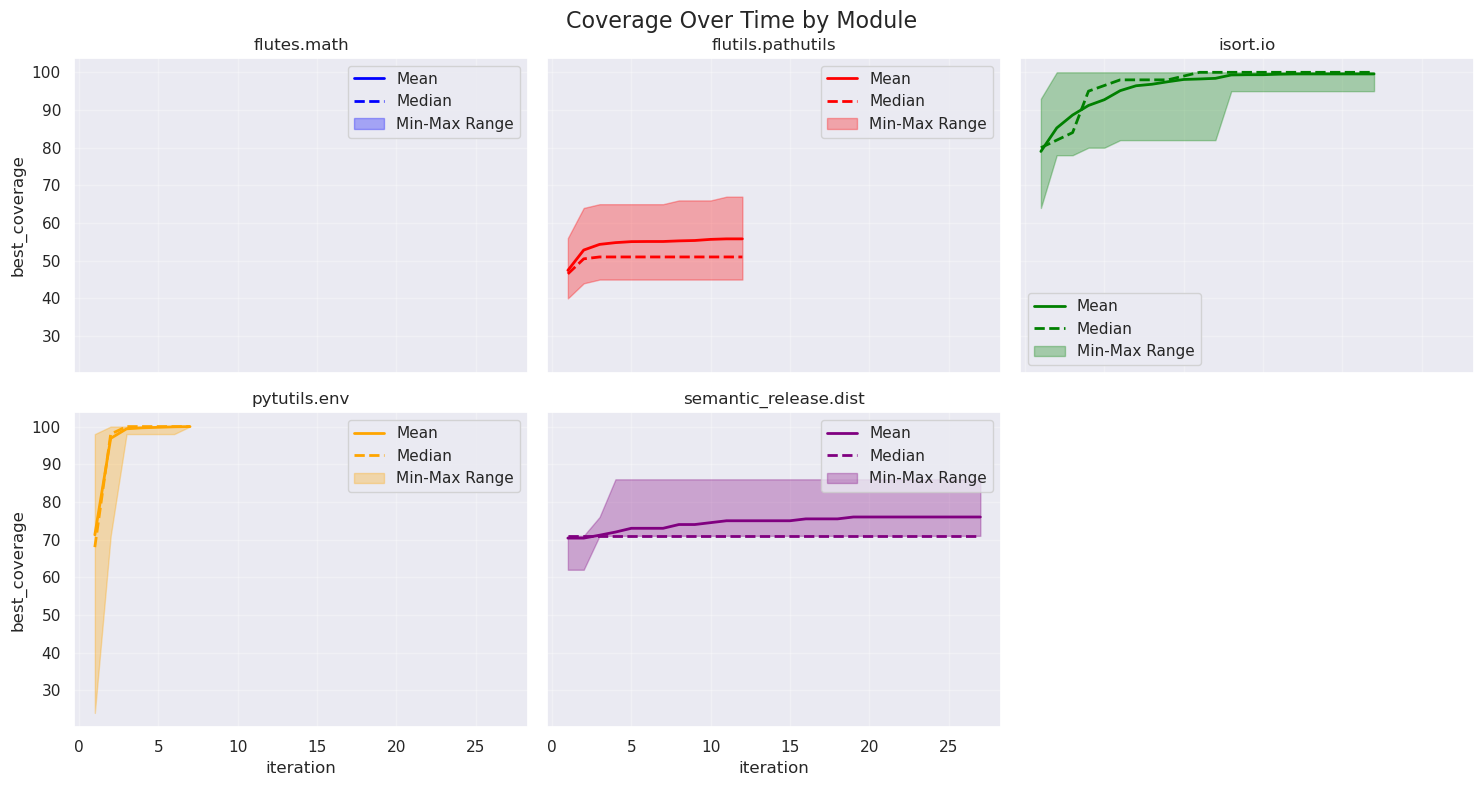

In [9]:
# Define colors for consistent plotting
colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']

# Plot with the original grouped data (no extension needed)
modules = sorted(grouped['module'].unique())
n_modules = len(modules)
n_cols = min(3, n_modules)
n_rows = (n_modules + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows), sharex=True, sharey=True)
axes = axes.flatten() if n_rows * n_cols > 1 else [axes]

for i, module in enumerate(modules):
    ax = axes[i]
    module_data = grouped[grouped['module'] == module]
    
    # Plot mean line
    ax.plot(module_data[time_column], module_data['mean'], 
            color=colors[i % len(colors)], 
            linewidth=2, 
            label='Mean')
    
    # Plot median line
    ax.plot(module_data[time_column], module_data['median'],
            color=colors[i % len(colors)],
            linestyle='--',
            linewidth=2,
            label='Median')
    
    # Add shaded area for min-max range
    ax.fill_between(module_data[time_column], 
                   module_data['min'], 
                   module_data['max'], 
                   color=colors[i % len(colors)], 
                   alpha=0.3, 
                   label='Min-Max Range')
    
    ax.set_title(f'{module}')
    ax.grid(True, alpha=0.3)
    ax.legend()
    
    if i % n_cols == 0:
        ax.set_ylabel(coverage_column)
    if i >= (n_rows - 1) * n_cols:
        ax.set_xlabel(time_column)

# Hide unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.suptitle('Coverage Over Time by Module', fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.92)

os.makedirs('figures', exist_ok=True)
plt.savefig('figures/coverage_over_time_by_module.png', dpi=300)
plt.show()


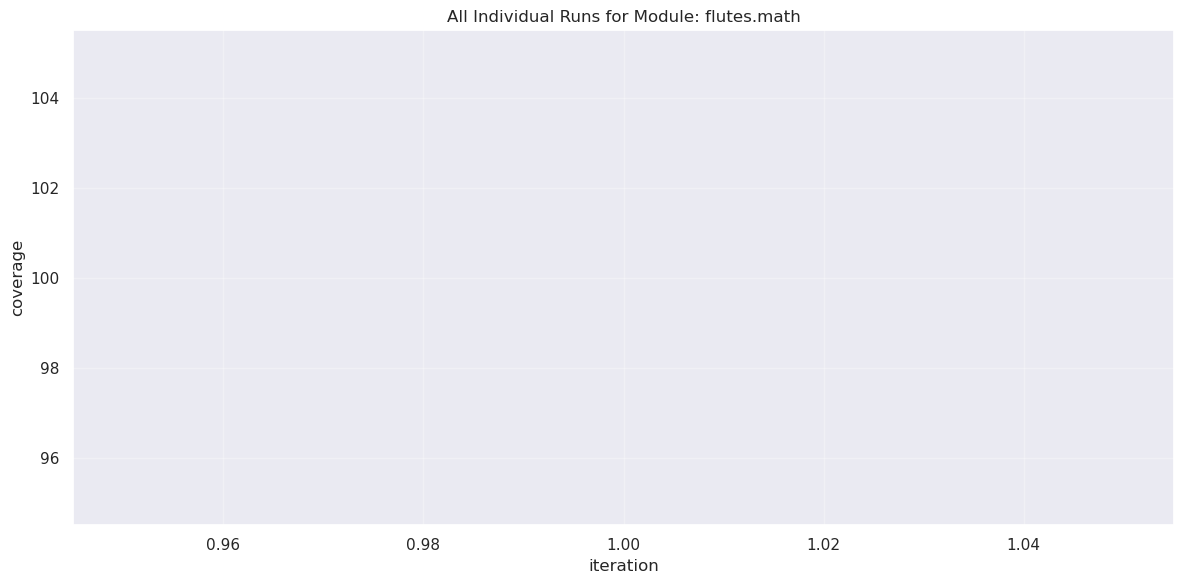

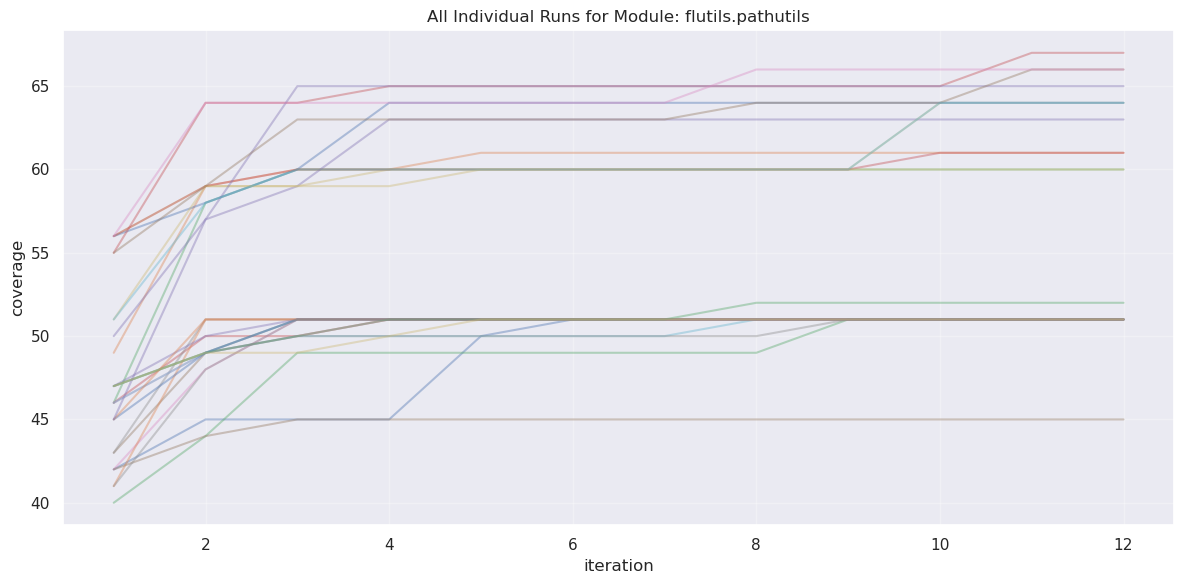

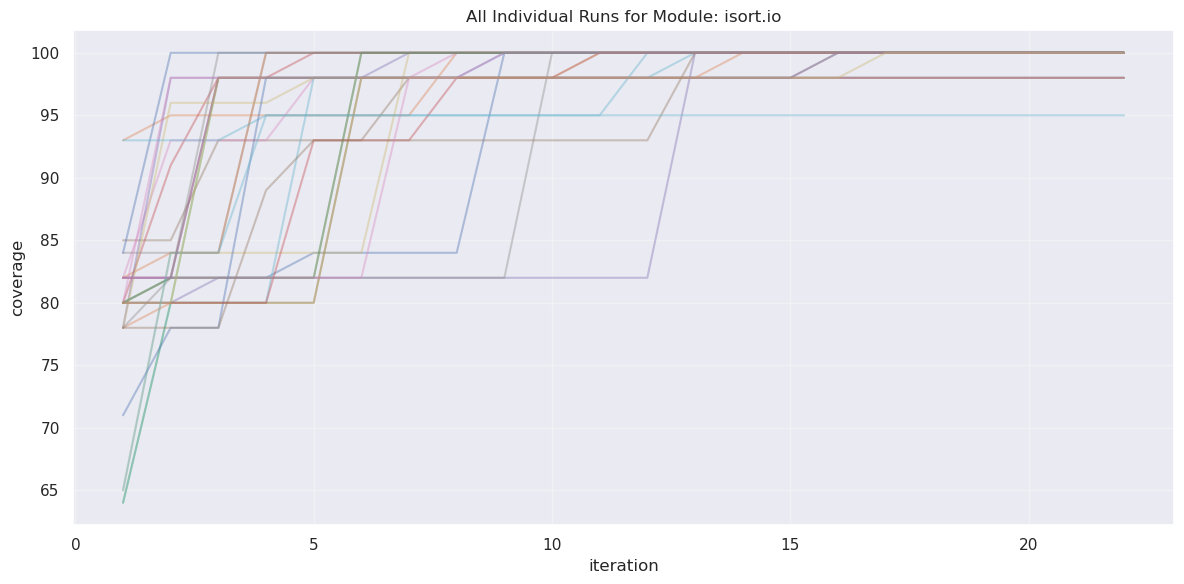

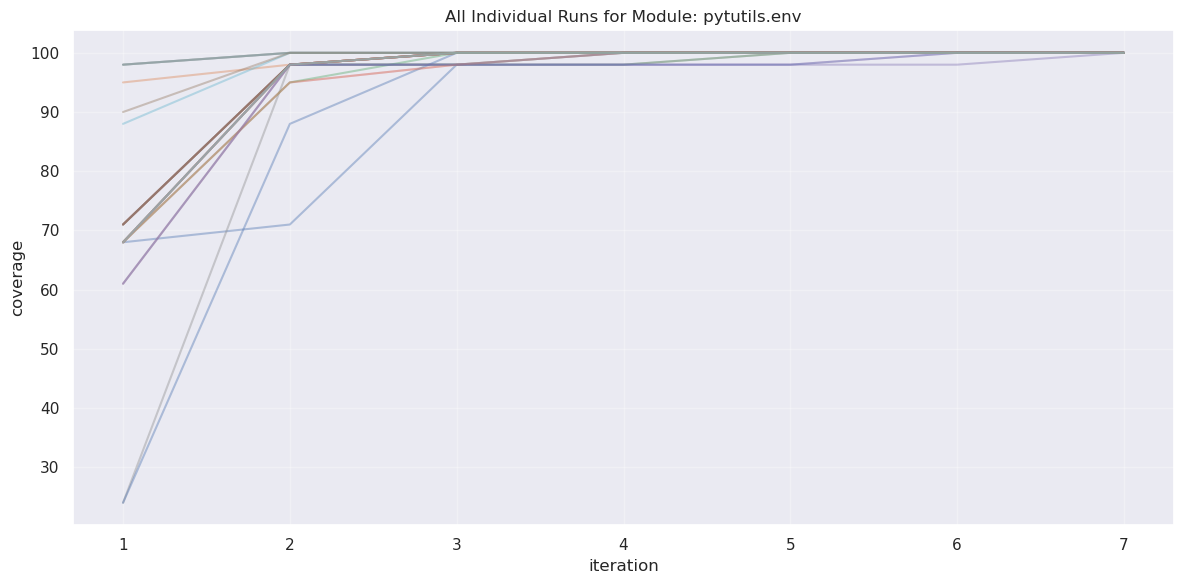

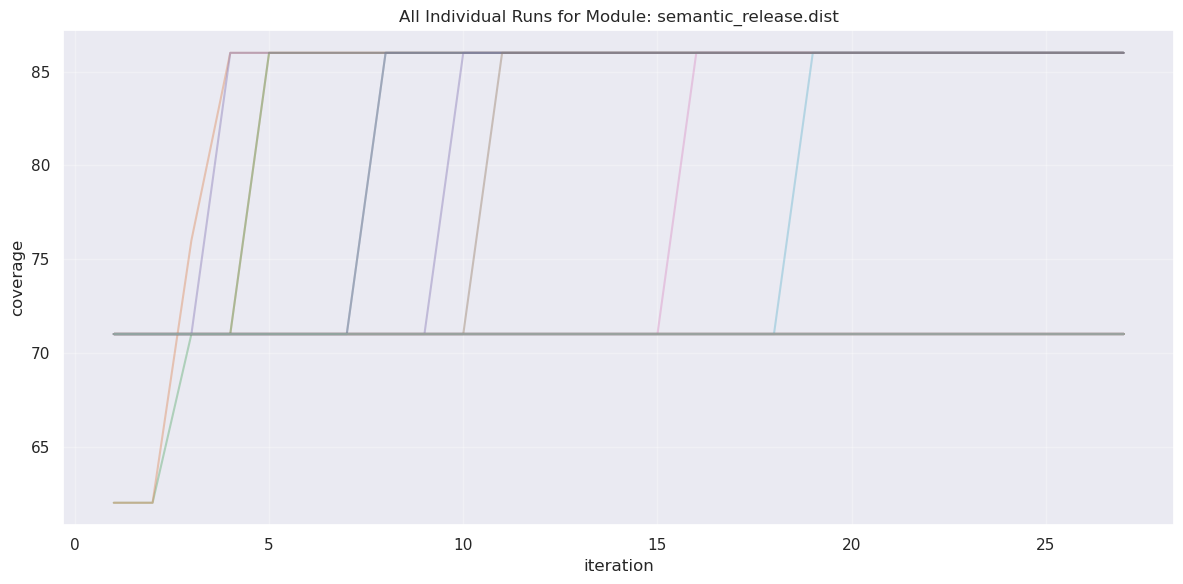

In [10]:
# Plot all individual runs for each module in one graph

for module in modules:
    plt.figure(figsize=(12, 6))
    module_data = combined_df[combined_df['module'] == module]
    for run_num, run_data in module_data.groupby('module_run_num'):
        plt.plot(run_data[time_column], run_data[coverage_column], alpha=0.4, label=f'Run {run_num}')
    plt.title(f'All Individual Runs for Module: {module}')
    plt.xlabel(time_column)
    plt.ylabel('coverage')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    # Optionally, comment out the next line if too many runs
    # plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
    plt.show()

## Analysis of Final Coverage by Experiment


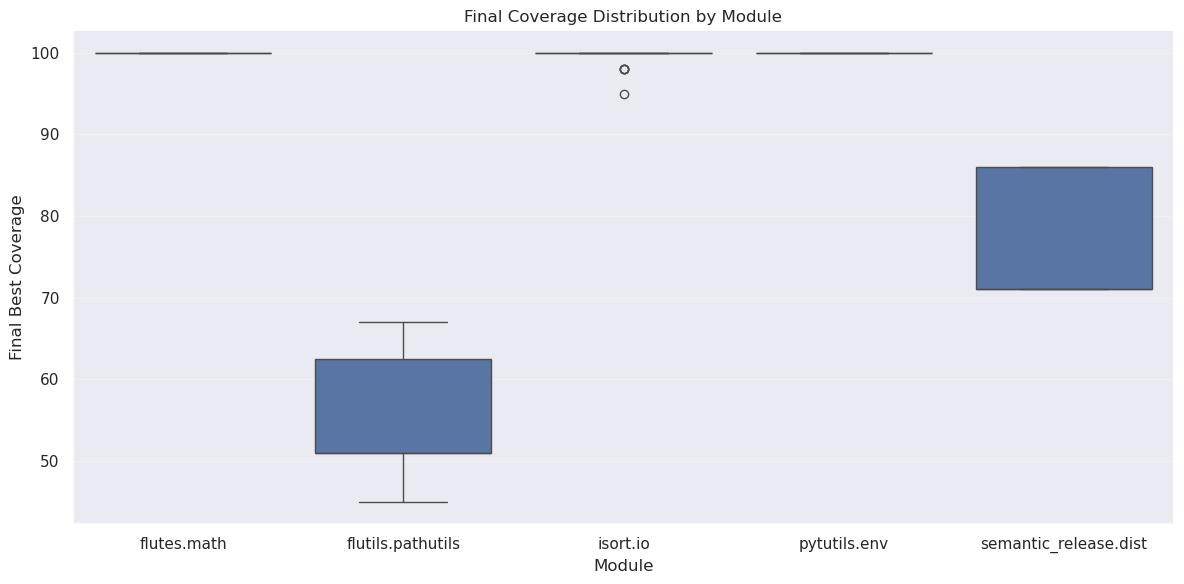

In [11]:
# Analyze the final coverage distribution by module as a boxplot

# For each run, get the final (max iteration) best_coverage
final_coverage = (
    combined_df
    .sort_values(['module', 'module_run_num', 'iteration'])
    .groupby(['module', 'module_run_num'])
    .tail(1)
)

plt.figure(figsize=(12, 6))
sns.boxplot(data=final_coverage, x='module', y='best_coverage')
plt.title('Final Coverage Distribution by Module')
plt.xlabel('Module')
plt.ylabel('Final Best Coverage')
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()